# **Homework 15 - Reinforcement Learning_a2c**

這裡是 report 第三題，關於如何使用 actor-critic


參考資料：   
1. https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
folder_path = './'

In [ ]:
import random
import torch
import numpy as np

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

## 前置作業

首先我們需要安裝必要的系統套件及 PyPi 套件。
gym 這個套件由 OpenAI 所提供，是一套用來開發與比較 Reinforcement Learning 演算法的工具包（toolkit）。
而其餘套件則是為了在 Notebook 中繪圖所需要的套件。

In [ ]:
%%capture 
# %%capture 
# IPython has a cell magic, %%capture, which captures the stdout/stderr of a cell. 
# With this magic you can discard these streams or store them in a variable.

# install process
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay piglet tqdm

接下來，設置好 virtual display，並引入所有必要的套件。

In [ ]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

%matplotlib inline
# %matplotlib inline 可以在Ipython編譯器裡直接使用，功能是可以內嵌繪圖，並且可以省略掉plt.show()這一步。
import matplotlib.pyplot as plt

from IPython import display

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from tqdm import tqdm_notebook

最後，引入 OpenAI 的 gym，並建立一個 [Lunar Lander](https://gym.openai.com/envs/LunarLander-v2/) 環境。

gym 小介紹：   
1. https://medium.com/pyladies-taiwan/reinforcement-learning-%E5%81%A5%E8%BA%AB%E6%88%BF-openai-gym-e2ad99311efc 
2. https://ithelp.ithome.com.tw/articles/10217736

In [ ]:
%%capture
import gym
# OpenAI Gym 是由 OpenAI 開源的 Reinforcement Learning 工具包，裡面有許多現成 environment 處理環境模擬及獎勵等等過程，讓開發者專注於演算法開發。
env = gym.make('LunarLander-v2')

## 什麼是 Lunar Lander？

“LunarLander-v2” 這個環境是在模擬登月小艇降落在月球表面時的情形。
這個任務的目標是讓登月小艇「安全地」降落在兩個黃色旗幟間的平地上。
> Landing pad is always at coordinates (0,0).
> Coordinates are the first two numbers in state vector.

![](https://gym.openai.com/assets/docs/aeloop-138c89d44114492fd02822303e6b4b07213010bb14ca5856d2d49d6b62d88e53.svg)

所謂的「環境」其實同時包括了 agent 和 environment。
我們利用 `step()` 這個函式讓 agent 行動，而後函式便會回傳 environment 給予的 observation/state（以下這兩個名詞代表同樣的意思）和 reward。

### Observation / State

首先，我們可以看看 environment 回傳給 agent 的 observation 究竟是長什麼樣子的資料：

In [ ]:
print(env.observation_space)

Box(8,)


`Box(8,)` 說明我們會拿到 8 維的向量作為 observation，其中包含：垂直及水平座標、速度、角度、加速度等等，這部分我們就不細說。

### Action

而在 agent 得到 observation 和 reward 以後，能夠採取的動作有：

In [ ]:
print(env.action_space)

Discrete(4)


`Discrete(4)` 說明 agent 可以採取四種離散的行動：
- 0 代表不採取任何行動
- 2 代表主引擎向下噴射
- 1, 3 則是向左右噴射

接下來，我們嘗試讓 agent 與 environment 互動。
在進行任何操作前，建議先呼叫 `reset()` 函式讓整個「環境」重置。
而這個函式同時會回傳「環境」最初始的狀態。

In [ ]:
initial_state = env.reset()
print(initial_state)

[ 0.00704393  1.4152572   0.713456    0.19273667 -0.00815534 -0.16160841
  0.          0.        ]


接著，我們試著從 agent 的四種行動空間中，隨機採取一個行動

In [ ]:
random_action = env.action_space.sample()
print(random_action)

2


再利用 `step()` 函式讓 agent 根據我們隨機抽樣出來的 `random_action` 動作。
而這個函式會回傳四項資訊：
- observation / state
- reward
- 完成與否
- 其餘資訊

In [ ]:
observation, reward, done, info = env.step(random_action)

第一項資訊 `observation` 即為 agent 採取行動之後，agent 對於環境的 observation 或者說環境的 state 為何。
而第三項資訊 `done` 則是 `True` 或 `False` 的布林值，當登月小艇成功著陸或是不幸墜毀時，代表這個回合（episode）也就跟著結束了，此時 `step()` 函式便會回傳 `done = True`，而在那之前，`done` 則保持 `False`。

In [ ]:
print(done)

False


### Reward

而「環境」給予的 reward 大致是這樣計算：
- 小艇墜毀得到 -100 分
- 小艇在黃旗幟之間成功著地則得 100~140 分
- 噴射主引擎（向下噴火）每次 -0.3 分
- 小艇最終完全靜止則再得 100 分

> Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points.
> If lander moves away from landing pad it loses reward back.
> Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points.
> Each leg ground contact is +10.
> Firing main engine is -0.3 points each frame.
> Solved is 200 points.

In [ ]:
print(reward)

-2.846440576236705


### Random Agent

最後，在進入實做之前，我們就來看看這樣一個 random agent 能否成功登陸月球：

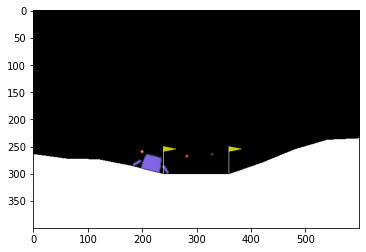

In [ ]:
env.reset()

img = plt.imshow(env.render(mode='rgb_array'))
# env.render() 視覺化呈現，它只會回應出呼叫那一刻的畫面給你，要它持續出現，需要寫個迴圈。

done = False
while not done:
    action = env.action_space.sample()
    observation, reward, done, _ = env.step(action)

    img.set_data(env.render(mode='rgb_array'))
    # img.set_data(self, A) => set the image array.

    display.display(plt.gcf())
    # display(obj, **kwargs) => Make a new display with my id, updating existing instances.
    # plt.gcf() => 得到當前的 figure

    display.clear_output(wait=True) # 在同個視窗顯示結果

# Actor-Critic

In [ ]:
# Actor module, categorical actions only
class Actor(nn.Module):
    def __init__(self):
        super().__init__()
        self.actor = nn.Sequential(
            nn.Linear(8, 16),
            # nn.ReLU(),
            nn.Tanh(),
            nn.Linear(16, 16),
            # nn.ReLU(),
            nn.Tanh(),
            nn.Linear(16, 4),
            nn.Softmax()
        )
    
    def forward(self, state):
        probs = self.actor(state)
        dist  = Categorical(probs)
        return dist

# Critic module
class Critic(nn.Module):
    def __init__(self):
        super().__init__()
        self.critic = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, state):
        state_value = self.critic(state)
        return state_value

最後，建立一個 Actor-Critic，就可以開始進行訓練了。

In [ ]:
actor = Actor()
critic = Critic()
# actor_optimizer = torch.optim.SGD(actor.parameters(), lr=0.001, momentum=0.9)
# critic_optimizer = torch.optim.SGD(critic.parameters(), lr=0.001, momentum=0.9)
actor_optimizer = torch.optim.Adam(actor.parameters(), lr=0.005)
critic_optimizer = torch.optim.Adam(critic.parameters(), lr=0.005)
print(actor)
print(critic)
print(actor_optimizer)
print(critic_optimizer)

Actor(
  (actor): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): Tanh()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): Tanh()
    (4): Linear(in_features=16, out_features=4, bias=True)
    (5): Softmax(dim=None)
  )
)
Critic(
  (critic): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)


## 訓練 Actor-Critic
現在我們開始訓練 Actor-Critic。

![alt text](https://imgur.com/lP1NOKV.png)


In [ ]:
# Mine
actor.train()  # 訓練前，先確保 actor 處在 training 模式
critic.train() # 訓練前，先確保 critic 處在 training 模式

NUM_BATCH = 180        # 訓練 100 次
EPISODE_PER_BATCH = 10  # batch = 10
gamma = 0.99           # 設定 gamma (discount factor)
best = -100000         # save model initial threshold
max_steps = 200        # step max threshold

avg_total_rewards, avg_final_rewards = [], []
avg_critic_losses, avg_actor_losses = [], []

prg_bar = tqdm_notebook(range(NUM_BATCH))

for batch in prg_bar: # 總共更新 "NUM_BATCH" 次

    total_rewards, final_rewards = [], []
    total_critic_loss, total_actor_loss = [], []
    log_probs = []
    advantages = []

    for episode in range(EPISODE_PER_BATCH): # 每蒐集 "EPISODE_PER_BATCH" 個 episodes 更新一次 agent
        
        rewards, state_values, dones = [], [], []
        state = env.reset()
        total_reward, total_step = 0, 0

        while True:

            # get action
            state = torch.FloatTensor(state) # numpy to tensor
            dist = actor(state)
            action = dist.sample()
            log_prob = dist.log_prob(action) # use log_prob to construct an equivalent loss function

            # get next state, reward
            next_state, reward, done, _ = env.step(action.detach().data.numpy())
            total_reward += reward

            # get state value
            state_value = critic(state)
            state = next_state

            # store data for 5 batches
            log_probs.append(log_prob)
            rewards.append(reward)
            state_values.append(state_value)
            dones.append(done)

            total_step += 1

            # if done or (total_step % max_steps == 0):
            if done :
                next_state = torch.FloatTensor(next_state)
                state_value_final = critic(next_state).detach().data.numpy() # get final state_value
                values = torch.stack(state_values) 
                q_vals = np.zeros((total_step, 1))

                final_rewards.append(reward)
                total_rewards.append(total_reward)
                    
                # target values are calculated backward
                # it's super important to handle correctly done states,
                # for those cases we want our to target to be equal to the reward only
                q_val = state_value_final

                # 用最後的 q_val 推到前面方法
                for i in range(total_step-1, -1, -1):
                    q_val = rewards[i] + gamma*q_val*(1.0-dones[i])
                    q_vals[i] = q_val # store values from the end to the beginning

                # # 用所有的 state_value 推到前面方法
                # for i in range(total_step-1, -1, -1):
                #     if(i == total_step-1): # state_value[i+1] == 0
                #         q_val = rewards[i] + gamma*state_value_final*(1.0-dones[i])
                #     else:
                #         q_val = rewards[i] + (gamma*values[i+1].detach().numpy())*(1.0-dones[i])
                #     q_vals[i] = q_val # store values from the end to the beginning               
                        
                advantage = torch.Tensor(q_vals) - values
                advantages.append(advantage.detach().numpy())
                break

    # 紀錄訓練過程，每次 epoch 的平均分數
    avg_total_reward = sum(total_rewards) / len(total_rewards)
    avg_final_reward = sum(final_rewards) / len(final_rewards)

    if(avg_total_reward > best):
        torch.save(actor.state_dict(), './actor_best.pth')
        torch.save(critic.state_dict(), './critic_best.pth')
        print('save model')
        best = avg_total_reward

    avg_total_rewards.append(avg_total_reward)
    avg_final_rewards.append(avg_final_reward)
    prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}") # 顯示進度

    advantages = np.concatenate(advantages, axis=0)
    advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-9) # normalize
    advantages = torch.from_numpy(advantages)

    # 更新 actor 網路    
    actor_loss = (-torch.stack(log_probs)*advantages.squeeze(1).detach()).sum()
    actor_optimizer.zero_grad()
    actor_loss.backward()
    actor_optimizer.step()
    total_actor_loss.append(actor_loss)

    # 更新 critic 網路
    critic_loss = advantages.pow(2).sum()
    critic_loss = critic_loss.requires_grad_()
    critic_optimizer.zero_grad()
    critic_loss.backward()
    critic_optimizer.step()
    total_critic_loss.append(critic_loss)

    avg_critic_loss = sum(total_critic_loss) / len(total_critic_loss)
    avg_actor_loss = sum(total_actor_loss) / len(total_actor_loss)
    avg_critic_losses.append(avg_critic_loss)
    avg_actor_losses.append(avg_actor_loss)

print(best)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model
save model

199.22246081412163


### 訓練結果

訓練過程中，我們持續記下了 `avg_total_reward`，這個數值代表的是：每次更新 policy network 前，我們讓 agent 玩數個回合（episodes），而這些回合的平均 total rewards 為何。
理論上，若是 agent 一直在進步，則所得到的 `avg_total_reward` 也會持續上升，直至 250 上下。
若將其畫出來則結果如下：

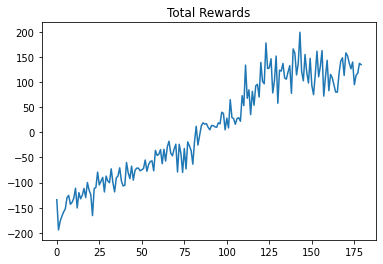

In [ ]:
plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

另外，`avg_final_reward` 代表的是多個回合的平均 final rewards，而 final reward 即是 agent 在單一回合中拿到的最後一個 reward。
如果同學們還記得環境給予登月小艇 reward 的方式，便會知道，不論**回合的最後**小艇是不幸墜毀、飛出畫面、或是靜止在地面上，都會受到額外地獎勵或處罰。
也因此，final reward 可被用來觀察 agent 的「著地」是否順利等資訊。

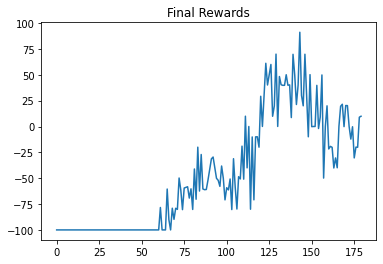

In [ ]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

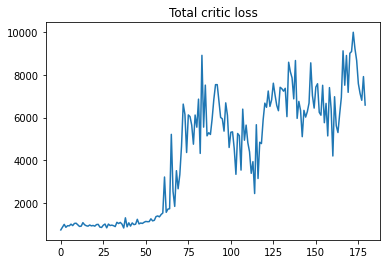

In [ ]:
plt.plot(avg_critic_losses)
plt.title("Total critic loss")
plt.show()

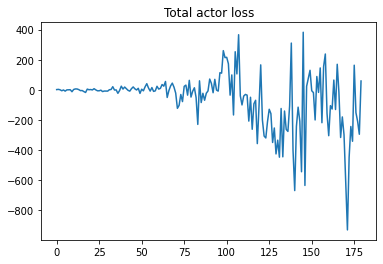

In [ ]:
plt.plot(avg_actor_losses)
plt.title("Total actor loss")
plt.show()

save model

In [ ]:
model = Actor()
model.load_state_dict(torch.load('actor_best.pth'))
torch.save(model.state_dict(), folder_path + 'actor_a2c_7_git_method_batch10_Adam_epoch180.pth')
# torch.save(model.state_dict(), folder_path + 'actor_a2c_3_my_method.pth')

## 測試

step = 1000
41.1698011613192
total_step = 1000


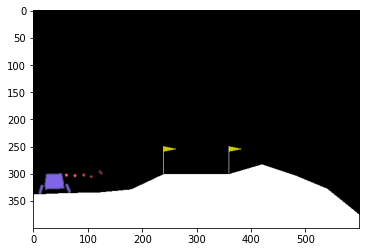

In [ ]:
# load model
model = Actor()
model.load_state_dict(torch.load(folder_path + 'actor_a2c_7_git_method_batch10_Adam_epoch180.pth'))
# model.load_state_dict(torch.load(folder_path + 'actor_a2c_4_my_method.pth'))
# model.load_state_dict(torch.load('actor_best.pth'))

# set eval mode
model.eval()  # 測試前先將 network 切換為 evaluation 模式

state = env.reset()

img = plt.imshow(env.render(mode='rgb_array'))

total_reward = 0
step = 0

done = False
# while (not done and step <= 300):
while (not done):
    state = torch.FloatTensor(state)
    dist = model(state)
    action = dist.sample()

    # get next state, reward
    next_state, reward, done, _ = env.step(action.detach().data.numpy())
    state = next_state
    total_reward += reward

    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)
    step += 1
    if(step%100 == 0):
        print('step =', step)

print(total_reward)
print('total_step =', step)

In [ ]:
print(total_reward)
print('total_step =', step)

41.1698011613192
total_step = 1000


## 參考資料

以下是一些有用的參考資料。
建議同學們實做前，可以先參考第一則連結的上課影片。
在影片的最後有提到兩個有用的 Tips，這對於本次作業的實做非常有幫助。

- [DRL Lecture 1: Policy Gradient (Review)](https://youtu.be/z95ZYgPgXOY)
- [ML Lecture 23-3: Reinforcement Learning (including Q-learning) start at 30:00](https://youtu.be/2-JNBzCq77c?t=1800)
- [Lecture 7: Policy Gradient, David Silver](http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching_files/pg.pdf)
